In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LassoCV, LassoLarsCV, ElasticNet, Lasso
from sklearn.preprocessing import scale, MinMaxScaler
import pickle
from sklearn.cross_validation import cross_val_score
from sklearn import svm
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from scipy.stats import skew
from scipy.stats.stats import pearsonr
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns = 50
sns.set_style('darkgrid')
matplotlib.rc('font', size=20)
matplotlib.rc('axes', titlesize=20)
matplotlib.rc('axes', labelsize=20)
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('legend', fontsize=20)
matplotlib.rc('figure', titlesize=20)
%matplotlib inline

/Users/sw/.venv/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_excel("train.xlsx")

## Data Preprocessing

#### Adjusting salary for skewness

/Users/sw/.venv/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


-0.09825249198384019

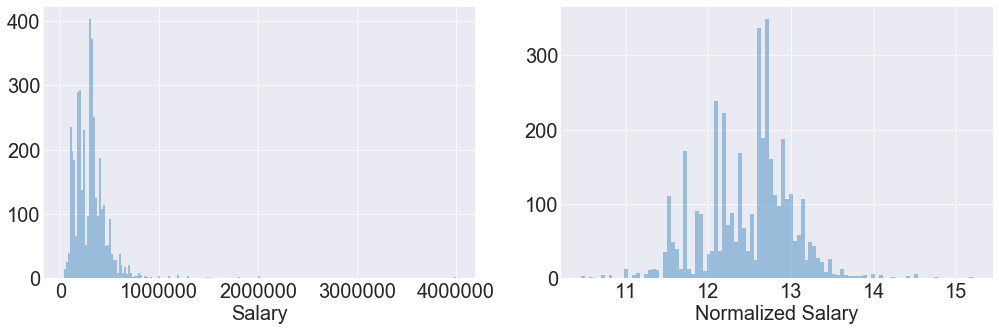

In [3]:
figure, (ax1,ax2) = plt.subplots(1,2,figsize = (17,5))
sns.distplot(train['Salary'], kde = False, ax = ax1, bins = 200)
sns.distplot(np.log1p(train["Salary"]), kde = False, axlabel = 'Normalized Salary', ax = ax2, bins = 100)
train['Salary'] = np.log1p(train["Salary"])
skew(train.Salary)

In [4]:
def convertTF(df,featureList):
    d = {True:1, False:0}
    for feature in featureList:
        df[feature] = df[feature].apply(lambda x: d[x])
    return df

def yearReturn(x):
    return x.year

def pos(x):
    if x > 0: 
        return 1
    else:
        return 0
def neg(x):
    if x < 0:
        return 1
    else:
        return 0

def val(x):
    if x > 0.44:
        return 3
    elif x < -0.44:
        return 1
    else:
        return 2

def conv_english(x) :
    if x >= 520:
        return 3
    elif x < 420:
        return 1
    else:
        return 2

def conv_logical(x) :
    if x >= 600:
        return 3
    elif x < 450:
        return 1
    else:
        return 2
    
def conv_quant(x) :
    if x >= 600:
        return 3
    elif x < 500:
        return 1
    else:
        return 2
    
def conv_prog(x) :
    if x >= 600:
        return 3
    elif x < 500:
        return 1
    else:
        return 2
    
def gpaCal(x):
    if x <= 10:
        return x*10
    else:
        return x
    
def isNationalBoard(row):
    if (row['isCbse'] or row['isISC'] or row['isICSE']):
        return 1
    else:
        return 0

def prepare(train):
    # Extract Designation
    train['isSenior'] = train.Designation.str.contains('senior')
    train['isSoftware'] = train.Designation.str.contains('software')
    train['isManager'] = train.Designation.str.contains('manager')
    train['isEngineer'] = train.Designation.str.contains('engineer')
    train['isDeveloper'] = train.Designation.str.contains('developer')
    
    # Extract Degree
    train['isBtech'] = train.Degree.str.contains('B.Tech/B.E.')
    train['isMCA'] = train.Degree.str.contains('MCA')
    train['isMtech'] = train.Degree.str.contains('M.Tech./M.E.')
    
    # Extract Board of Examination
    train['isCbse'] = train['12board'].str.contains('cbse')
    train['isStateBoard'] = train['12board'].str.contains('state board')
    train['isISC'] = train['12board'].str.contains('isc')
    train['isICSE'] = train['12board'].str.contains('icse')
    train['isCbse'].fillna(value = False, inplace = True)
    train['isStateBoard'].fillna(value = False, inplace = True)
    train['isISC'].fillna(value = False, inplace = True)
    train['isICSE'].fillna(value = False, inplace = True)
    train['isNationalBoard'] = 0
    train['isNationalBoard'] = train.apply(lambda x : isNationalBoard(x), axis=1)
    
    
    # Extract Specialization
    train['isCSE'] = train.Specialization.str.contains('computer engineering')
    train['isECE'] = train.Specialization.str.contains('electronics and communication engineering')
    train['isIT'] = train.Specialization.str.contains('information technology')
    train['isMech'] = train.Specialization.str.contains('mechanical engineering')
    train['isICE'] = train.Specialization.str.contains('instrumentation and control engineering')
    train['isEE'] = train.Specialization.str.contains('electrical engineering')
    
    train = convertTF(train, ['isCbse', 'isStateBoard', 'isISC', 'isICSE', 'isBtech', 'isMCA', 'isMtech', 'isSenior', 'isSoftware', 'isManager', 'isEngineer', 'isDeveloper','isCSE', 'isECE', 'isIT', 'isMech', 'isICE', 'isEE'])
    
    # Cleaning
    m = train.ComputerProgramming.mean(skipna=True)
    train.ComputerProgramming.fillna(m, inplace=True)

    n = train.Domain.mean(skipna=True)
    train.Domain.fillna(n, inplace=True)

    train.GraduationYear.replace(0,None,inplace=True)
    m = train.GraduationYear.mean(skipna=True)
    train.GraduationYear.fillna(m, inplace=True)
    
    # Generate Features

    #MaxDomain : max of the domains in one column
    train['maxDomain'] = train[['ComputerProgramming','ComputerScience','ElectronicsAndSemicon','MechanicalEngg','ElectricalEngg','TelecomEngg','CivilEngg']].max(axis=1)

    # diffGrad : difference between Graduation Year & 12th graduation, to see whether drop in college affect scores
    train['diffGrad'] = train.GraduationYear - train['12graduation']

    # diffGradDOB : difference between Graduation Year and DOB
    train['DOBY'] = train.DOB.apply(yearReturn)
    train['diffGradDOB'] = train.GraduationYear - train.DOBY
    
    # Big Five scores
    train['bigfive'] = 0
    train.bigfive += train.agreeableness.apply(lambda x : val(x))
    train.bigfive += train.conscientiousness.apply(lambda x : val(x))
    train.bigfive += train.nueroticism.apply(lambda x : val(x))
    train.bigfive += train.extraversion.apply(lambda x : val(x))
    train.bigfive += train.openess_to_experience.apply(lambda x : val(x))
    
    # Translate English / Logical / Quants scores
    train['scores'] = 0
    train['scores'] += train.English.apply(lambda x : conv_english(x))
    train['scores'] += train.Logical.apply(lambda x : conv_logical(x))
    train['scores'] += train.Quant.apply(lambda x : conv_quant(x))
    train['scores'] += train.ComputerProgramming.apply(lambda x : conv_prog(x))
    
    # Fix GPA to 100 scale
    train['mcolgGPA'] = train.collegeGPA.apply(lambda x: gpaCal(x))
    
    #Feature columns to take
    feature_cols = ['10percentage','12percentage', 'mcolgGPA', 'CollegeTier','CollegeCityTier', 'GraduationYear','scores','Domain','maxDomain','bigfive','diffGradDOB','isCSE','isIT','isECE','isMech','isICE','isEE']
    X = train[feature_cols]
    y = train.Salary
    
    return X,y

In [5]:
X, Y = prepare(train)

In [ ]:
cols = ['10percentage','12percentage', 'mcolgGPA', 'CollegeTier','CollegeCityTier', 'GraduationYear','scores','Domain','maxDomain','bigfive','diffGradDOB','isCSE','isIT','isECE','isMech','isICE','isEE']

sns.pairplot(train, x_vars = cols[:4], y_vars = 'Salary', size = 7, aspect = 0.7)
sns.pairplot(train, x_vars = cols[4:8], y_vars = 'Salary', size = 7, aspect = 0.7)
sns.pairplot(train, x_vars = cols[8:12], y_vars = 'Salary', size = 7, aspect = 0.7)
sns.pairplot(train, x_vars = cols[12:], y_vars = 'Salary', size = 7, aspect = 0.7)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size= 0.2 ,random_state = 1)
X_train.head()

### Computing Skewness

(Result: Within Acceptable Limits)

In [ ]:
classes = ['10percentage', '12percentage', 'mcolgGPA', 'GraduationYear', 'maxDomain', 'Domain', 'bigfive', 'diffGradDOB']
X_u = pd.DataFrame()
for c in classes:
    param = X_train[c] 
    skness = skew(param) 
    figure = plt.figure(figsize=(30,5))
    figure.add_subplot(121)   
    plt.hist(param,facecolor='blue',alpha=0.5, bins=100) 
    plt.xlabel(c + " - Distribution") 
    plt.title("Skewness: {0:.2f}".format(skness)) 
    plt.show()

In [ ]:
def cv_error(model):
    cve= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="mean_squared_error", cv = 5))
    return(cve)

In [ ]:
def display_metrics(y_test, y_pred):
    print ("MAE : %f" % metrics.mean_absolute_error(y_test, y_pred))
    print ("RMSE : %f" % np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print ("\n")

def model_train(model,X,y):
    # split test, train
    X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 1)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    display_metrics(y_test, y_pred)
    plt.figure(figsize= (50,10))
    preds = pd.DataFrame({"Predicted":model.predict(X_test), "true":y_test})
    preds["Difference"] = preds["true"] - preds["Predicted"]
    preds.plot(x = "Predicted", y = "Difference",kind = "scatter", title = "Residual Features")
    plt.show()
    
def training(X,y):   
    
    #SVM Regression
    svm_clf = svm.SVR()
    print ("SVM Regression")
    model_train(svm_clf, X, y)
    
    #Random Forests
    rand_clf = RandomForestRegressor(n_estimators = 1500,max_features='sqrt')
    print ("Random Forests")
    model_train(rand_clf, X, y)
    
    #Linear SVM Regression
    ridge_clf = Ridge(alpha=0.1)
    print ("Ridge Regression")
    model_train(ridge_clf, X, y)
    
    #Lasso Regression
    lasso_clf = linear_model.Lasso(alpha=0.001, selection="random", random_state=1)
    print ("Lasso Regression")
    model_train(lasso_clf, X, y)
    
    #Linear Regression
    mlp_clf = MLPRegressor(solver = 'lbfgs', alpha = 0.01, hidden_layer_sizes=(10,10), random_state= 1)
    print ("MLP (NN)")
    model_train(mlp_clf, X, y)

    
    return svm_clf, rand_clf, ridge_clf, lasso_clf, mlp_clf

svm_clf, rand_clf, linear_svm_clf, lasso_clf, linear_clf = training(X, Y)


In [ ]:
svm = svm.SVR(C=.01, kernel='linear')
svm.fit(X,Y)

In [ ]:
coef = pd.Series(svm.coef_[0], index = X.columns)
relevant_Coeff = coef.sort_values().tail(10)
irrelevant_Coeff = coef.sort_values().head(10)

#Plots
plt.figure(figsize=(20,10))
relevant_Coeff.plot(kind = "barh", title="Most Relevant Aspects that affect placements of graduates positively")

In [ ]:
test  = pd.read_excel('test.xlsx', na_values=-1)
X, y = prepare(test)
def testing(X, model, ds, file_name):
    y_pred = np.expm1(model.predict(X))
    submission = pd.DataFrame(columns=['ID','Salary'])
    submission.ID = ds.ID
    submission.Salary = y_pred
    writer_orig = pd.ExcelWriter(file_name, engine='xlsxwriter')
    submission.to_excel(writer_orig, index=False, sheet_name='report')
    writer_orig.save()
testing(X, lasso_clf, test, 'result.xlsx')

In [ ]:
y  = pd.read_excel('result.xlsx', na_values=-1)

In [ ]:
y.mean()

In [ ]:
plt.hist(y.Salary, bins=200)


In [ ]:
filename = 'finalized_model.sav'
pickle.dump(lasso_clf, open(filename, 'wb'))

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
test  = pd.read_excel('test.xlsx', na_values=-1)
X, y = prepare(test)
def testing(X, model, ds, file_name):
    y_pred = np.expm1(model.predict(X))
    submission = pd.DataFrame(columns=['ID','Salary'])
    submission.ID = ds.ID
    submission.Salary = y_pred
    writer_orig = pd.ExcelWriter(file_name, engine='xlsxwriter')
    submission.to_excel(writer_orig, index=False, sheet_name='report')
    writer_orig.save()
testing(X, loaded_model, test, 'result2.xlsx')

In [ ]:
print (lasso_clf.__dict__)